### 1. Импорт библиотек и предварительная настройка

In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Выбор устройства, на котором будут производиться вычисления. В моем случае это CPU.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Объявление некоторых параметров обучения, а также меток классов.

In [3]:
epochs = 15
batch_size = 64
classes = ('female', 'male')

### 2. Загрузка и предобработка изображений

In [4]:
image_transforms = transforms.Compose([transforms.Resize((100,80)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                           std=(0.5, 0.5, 0.5))
                                      ])

dataset = datasets.ImageFolder('./data/', transform=image_transforms)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [80002, 10000, 10000])

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size=1,
                                         shuffle=False, 
                                         num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=2)

Для подачи изображений на вход нейронной сети их необходимо преобразовать к единому формату.   

image_transforms отвечает за преобразование изображений к нужному формату: изменяет размер изображения, конвертирует в тензор и нормализует данные.

Я привел размеры изображений к формату 100х80, чтобы обучение нейронной сети заняло приемлемое время. Преобразование изображений к более высокому разрешению существенно увеличивало время обучения. С учётом того, что обучение я осуществлял на CPU, пришлось пожертвовать качеством картинок. 

Далее с помощью функции random_split разбил датасет на тренировочный, валидационный и тестовый наборы данных для обучения и оценки качества нейронной сети. После этого загрузил наборы данных через DataLoader с указанием размера минивыборки, а также параметрами последовательной/перемешанной загрузки данных и многопоточности.

Используемая в задаче метрика качества accuracy может быть не очень показательной в случаях, когда есть сильный перевес по количеству объектов в сторону одного из классов. Поэтому полезно убедиться, что объекты исходного набора данных распределены равномерно. Следующие гистограммы показывают распределение объектов каждого из классов в загруженных данных. 

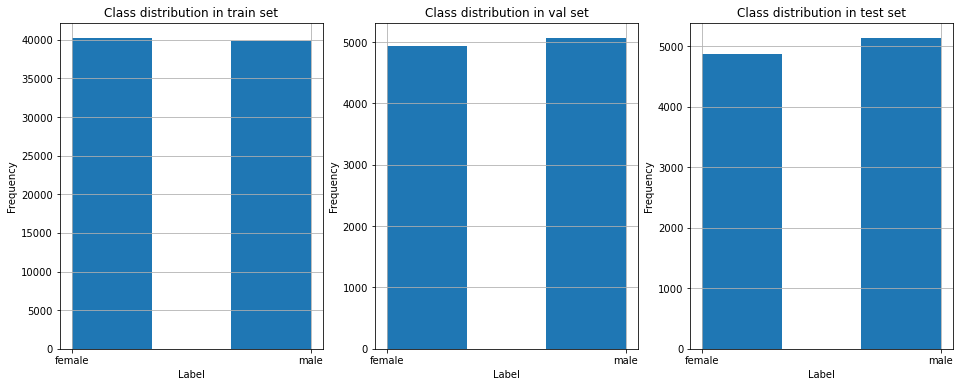

In [5]:
datasets = (train_set, val_set, test_set)
titles = ('train set', 'val set', 'test set')

fig = plt.figure(figsize=(16,6))

for i, dataset in enumerate(datasets):
    
    labels = np.array([])
    for j in range(len(dataset)):
        labels = np.append(labels, dataset[j][1])
    unique_elements = np.unique(labels)
    
    ax = fig.add_subplot(1,3,i+1)
    ax.grid()
    plt.hist(labels, bins=3)
    plt.title(f'Class distribution in {titles[i]}')
    plt.ylabel('Frequency')
    plt.xlabel('Label')
    plt.xticks(unique_elements, ['female','male'])
plt.show()

Вот примеры изображений из первой минивыборки обучающих данных.

In [6]:
# функция image_show убирает нормализацию изображения и преобразует его из формата тензора в массив numpy
def image_show(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

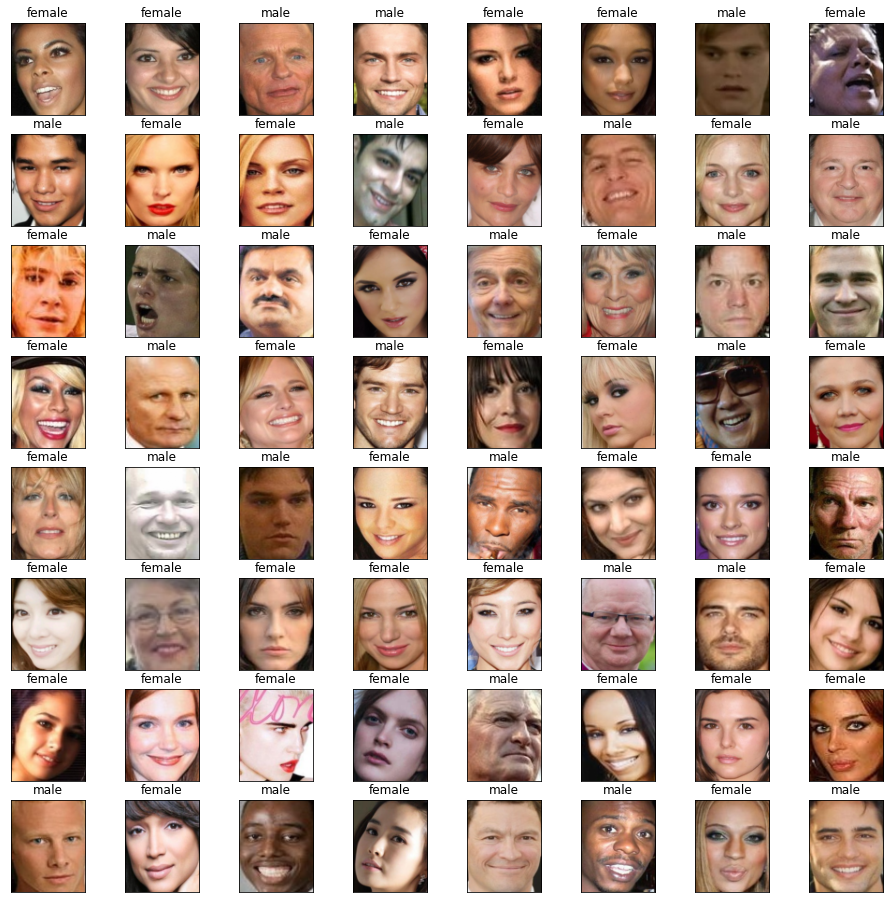

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(16,16))
plot_size = batch_size
for i in range(plot_size):
    ax = fig.add_subplot(8, plot_size/8, i+1, xticks=[], yticks=[])
    ax.set_title(classes[labels[i]])
    image_show(images[i])

### 3. Создание модели нейронной сети

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(in_features=512, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=412)
        self.fc4 = nn.Linear(in_features=412, out_features=2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

В данной модели нейронной сети я использовал 3 сверточных слоя с функциями активации ReLU и 4 линейных слоя также с функциями активации ReLU (кроме последнего слоя, у которого нет функции активации). К каждому сверточному слою также применяется слой пуллинга.

Инициализируем модель и отправляем на ранее выбранное устройство.

In [9]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=2, bias=True)
)

Объявляем функцию потерь и тип оптимизатора. Я использую CrossEntropyLoss в качестве функции потерь и оптимизатор Adam с коэффициентом обучения 0.0003.

In [10]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.0003)

Метрикой оценки качества нейронной сети является accuracy.

### 4. Обучение нейронной сети

Обучение нейросети будет происходить на 15 эпохах с размером минивыборки: 64 изображения.
В процессе тренировки я сохраняю историю обучения для дальнейшей визуализации. Кроме этого, каждую эпоху я сохраняю состояние нейросети для возможности выбора оптимальной модели, а также на случай переобучения и необходимости отката к более раннему состоянию.

In [11]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []} # словарь для сохранения результатов обучения

start_train = datetime.datetime.now()

for epoch in range(epochs):
    model.train()
    train_loss, train_corr = 0, 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device=device, non_blocking=True)
        labels = labels.to(device=device, non_blocking=True)
        optimiser.zero_grad() # очищаем градиенты
        outputs = model(inputs) # прямое распространение
        loss = criterion(outputs, labels) # рассчет ошибки
        loss.backward() # вычисление градиента
        optimiser.step() # градиентный шаг
        train_loss += loss.item()

        pred = outputs.argmax(1, keepdim=True)
        train_corr += pred.eq(labels.view_as(pred)).sum().item() # подсчет количества верных предсказаний

    # расчет средней ошибки и оценка качества на обучающей выборке
    train_loss /= (len(train_set) / batch_size)
    train_acc = train_corr / len(train_set)
            
    # промежуточная оценка качества на валидационной выборке
    model.eval()
    val_loss, val_corr = 0, 0
    with torch.no_grad():
        for inputs, label in val_loader:
            inputs = inputs.to(device=device, non_blocking=True)
            label = label.to(device=device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, label)
            val_loss += loss.item()
            pred = outputs.argmax(1, keepdim=True)
            val_corr += pred.eq(label.view_as(pred)).sum().item()

    # расчет средней ошибки и оценка качества на валидационной выборке
    val_loss /= len(val_set)
    val_acc = val_corr / len(val_set)
    
    # сохранение результатов обучения
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # вывод результатов обучения за эпоху
    print('Epoch %02d - Train_loss: %.4f, Train_acc: %.4f | Val_loss: %.4f, Val_acc: %.4f' % (epoch+1, train_loss, train_acc, val_loss, val_acc))
    
    # сохранение параметров модели
    torch.save(model.state_dict(), './model/model_state-epoch-%02d-val_acc-%.4f.pth' % (epoch+1, val_acc))
    
fit_time = datetime.datetime.now() - start_train # рассчет времени обучения
print(f'Finished, fitness time: {fit_time}')

Epoch 01 - Train_loss: 0.2489, Train_acc: 0.8920 | Val_loss: 0.2259, Val_acc: 0.9050
Epoch 02 - Train_loss: 0.1437, Train_acc: 0.9437 | Val_loss: 0.1349, Val_acc: 0.9460
Epoch 03 - Train_loss: 0.1122, Train_acc: 0.9567 | Val_loss: 0.1283, Val_acc: 0.9495
Epoch 04 - Train_loss: 0.0969, Train_acc: 0.9628 | Val_loss: 0.1306, Val_acc: 0.9543
Epoch 05 - Train_loss: 0.0849, Train_acc: 0.9677 | Val_loss: 0.1310, Val_acc: 0.9529
Epoch 06 - Train_loss: 0.0735, Train_acc: 0.9723 | Val_loss: 0.1096, Val_acc: 0.9584
Epoch 07 - Train_loss: 0.0648, Train_acc: 0.9764 | Val_loss: 0.1228, Val_acc: 0.9536
Epoch 08 - Train_loss: 0.0558, Train_acc: 0.9798 | Val_loss: 0.1120, Val_acc: 0.9595
Epoch 09 - Train_loss: 0.0493, Train_acc: 0.9820 | Val_loss: 0.1356, Val_acc: 0.9584
Epoch 10 - Train_loss: 0.0420, Train_acc: 0.9846 | Val_loss: 0.1410, Val_acc: 0.9596
Epoch 11 - Train_loss: 0.0359, Train_acc: 0.9868 | Val_loss: 0.1362, Val_acc: 0.9561
Epoch 12 - Train_loss: 0.0317, Train_acc: 0.9886 | Val_loss: 0.16

#### Визуализация процесса обучения

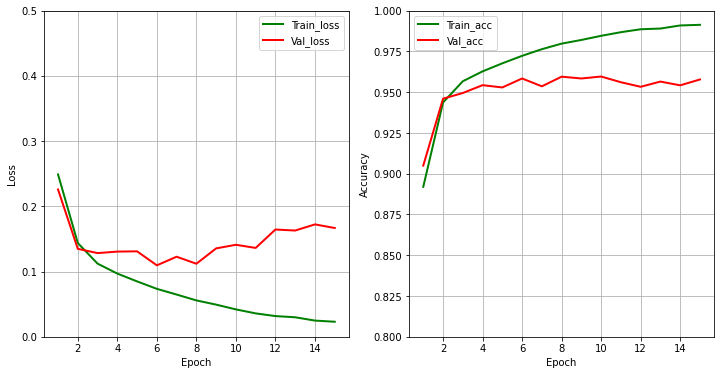

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, 
                               ncols=2, 
                               figsize=(12, 6))
    
grid = [int(i) for i in range(1, len(history['train_loss']) + 1)]
ax1.plot(grid, history['train_loss'], 'g', linewidth=2)
ax1.plot(grid, history['val_loss'], 'r', linewidth=2)
ax1.legend(['Train_loss', 'Val_loss'])
ax1.grid()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim([0, 0.5])

ax2.plot(grid, history['train_acc'], 'g', linewidth=2)
ax2.plot(grid, history['val_acc'], 'r', linewidth=2)
ax2.legend(['Train_acc', 'Val_acc'])
ax2.grid()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0.8, 1])


plt.show()

Как можно заметить из лога обучения, а также из графиков, на валидационной выборке нейросеть выдавала не стабильный результат при уверенном снижении функционала ошибки на тренировочных данных. После 8ой эпохи ошибка стала заметно увеличиваться, что говорит о переобучении модели. При этом качество работы оставалось на уровне 95 - 96%.
Время обучения составило 5 часов.

### 5. Оценка качества модели на тестовых данных

In [14]:
def test_model(model):
    model.eval()
    test_loss, test_corr = 0, 0

    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device=device, non_blocking=True)
            label = label.to(device=device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, label)
            test_loss += loss.item()
            pred = outputs.argmax(1, keepdim=True)
            test_corr += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_set)
    test_acc = test_corr / len(test_set)
    print('Test_loss: %.4f, Test_accuracy: %.4f' % (test_loss, test_acc))

Для начала протестируем финальную модель, прошедшую 15 эпох обучения.

In [15]:
test_model(model)

Test_loss: 0.1510, Test_accuracy: 0.9616


А теперь проверим модель после 6ой эпохи обучения. Она показала наименьшую ошибку в ходе обучения.

In [16]:
model_best_val = Net().to(device)
model_best_val.load_state_dict(torch.load('./model/model_state-epoch-06-val_acc-0.9584.pth'))

<All keys matched successfully>

In [17]:
test_model(model_best_val)

Test_loss: 0.1056, Test_accuracy: 0.9590


В итоге, несмотря на существенную разницу в ошибке, обе модели показывают примерно одинаковое качество. Однако я отдам предпочтение модели с меньшим показателем ошибки. Ее я и приложу в качестве ответа на задание.